In [1]:
!pip install torch torchvision datasets sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
!pip install datasets

  Using cached datasets-3.4.1-py3-none-any.whl.metadata (19 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 5.2 MB/s eta 0:00:00


In [3]:
# Importer les modules nécessaires
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [4]:
# Charger le dataset depuis Hugging Face
dataset = load_dataset("PedroSampaio/fruits-360")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.58k [00:00<?, ?B/s]

(…)-00000-of-00001-086dc013443c484c.parquet:   0%|          | 0.00/299M [00:00<?, ?B/s]

(…)-00000-of-00001-0d294abe3826b2e6.parquet:   0%|          | 0.00/98.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67690 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/22688 [00:00<?, ? examples/s]

In [5]:
# Définir les transformations pour les images
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),  # Convertir en tenseur
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisation
])

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 67690
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 22688
    })
})

In [7]:
# Vérifier les clés disponibles dans le dataset
print(dataset.keys())


dict_keys(['train', 'test'])


In [8]:
# Afficher un exemple d'image et son label
print("Exemple du dataset :", dataset["train"][0])


Exemple du dataset : {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=100x100 at 0x793F69456490>, 'label': 0}


In [9]:
# CONVERTIR LE DATASET EN FORMAT COMPATIBLE AVEC PyTorch
class FruitsDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]["image"].convert("RGB")  # Convertir l'image en mode RGB
        label = self.dataset[idx]["label"]  # Récupérer le label

        if self.transform:
            image = self.transform(image)  # Appliquer la transformation

        return image, torch.tensor(label)  # Retourner un tenseur PyTorch

# Appliquer les transformations et préparer les datasets
train_dataset = FruitsDataset(dataset["train"], transform=transform)
test_dataset = FruitsDataset(dataset["test"], transform=transform)


In [10]:
# Créer les DataLoaders pour PyTorch
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
# AFFICHER QUELQUES IMAGES DU DATASET
def show_images(dataset, num_images=20, num_cols=5):
    num_rows = (num_images // num_cols) + (1 if num_images % num_cols != 0 else 0)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 2.5))

    index = 0
    for row in range(num_rows):
        for col in range(num_cols):
            if index < num_images:
                image, label = dataset[index]
                axes[row, col].imshow(image.permute(1, 2, 0))
                axes[row, col].set_title(f"Fruit {label.item()}")
                axes[row, col].axis("off")
                index += 1
            else:
                axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()

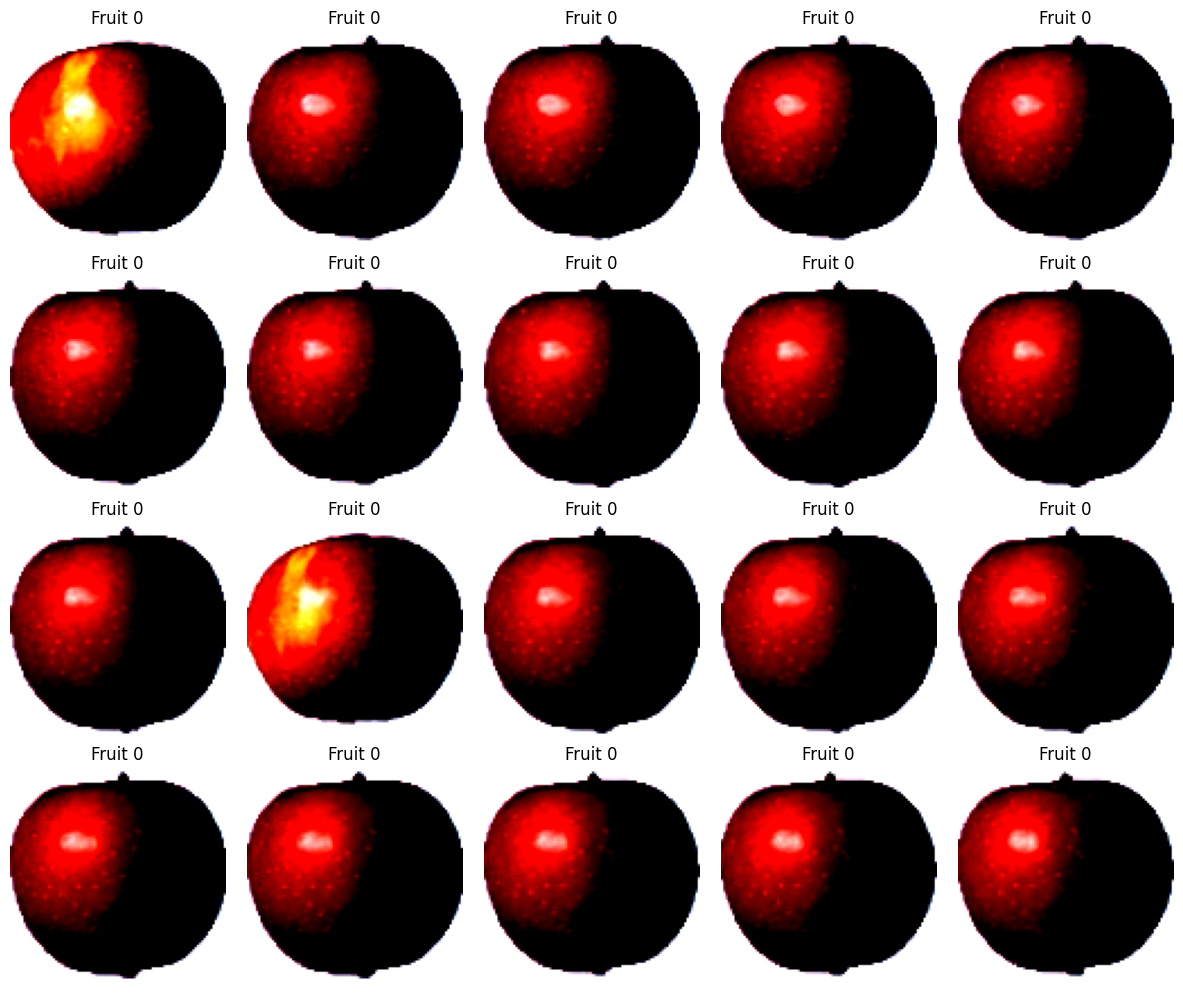

In [12]:
# Afficher quelques images du dataset
show_images(train_dataset, num_images=20, num_cols=5)


In [13]:
# Charger ResNet50 pré-entraîné
model = models.resnet50(pretrained=True)

# Modifier la dernière couche pour s'adapter au nombre de classes
num_classes = len(dataset["train"].features["label"].names)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Déplacer le modèle sur GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Définir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 60.0MB/s]


In [14]:
# ENTRAÎNEMENT DU MODÈLE

num_epochs = 5  # Modifier selon les besoins

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/5], Loss: 0.3094
Epoch [2/5], Loss: 0.0549
Epoch [3/5], Loss: 0.0381
Epoch [4/5], Loss: 0.0257
Epoch [5/5], Loss: 0.0177


In [15]:
# ÉVALUATION DU MODÈLE

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


In [ ]:
class_names = dataset["train"].features["label"].names  # Récupère les noms des classes


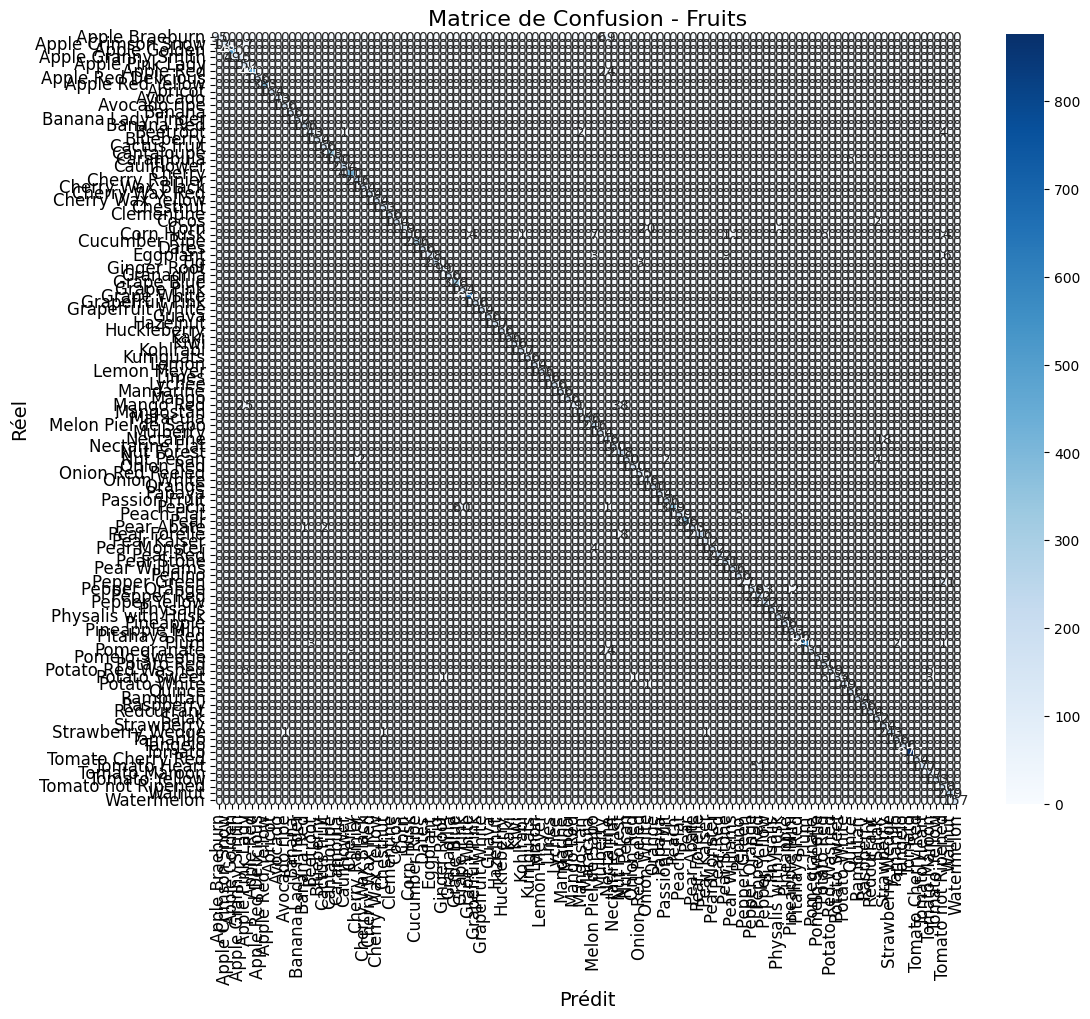

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Calcul de la matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# Affichage avec les noms des fruits
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)  # Utilisation des noms des fruits
plt.xticks(rotation=90, fontsize=12)  # Rotation pour éviter le chevauchement
plt.yticks(fontsize=12)
plt.xlabel("Prédit", fontsize=14)
plt.ylabel("Réel", fontsize=14)
plt.title("Matrice de Confusion - Fruits", fontsize=16)
plt.show()


In [ ]:
plt.figure(figsize=(12, 10))  # Augmente la taille
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5,
            xticklabels=class_names, yticklabels=class_names)

plt.xticks(rotation=90, fontsize=12)  # Rotation pour éviter le chevauchement
plt.yticks(fontsize=12)
plt.xlabel("Prédit", fontsize=14)
plt.ylabel("Réel", fontsize=14)
plt.title("Matrice de Confusion Améliorée", fontsize=16)
plt.show()


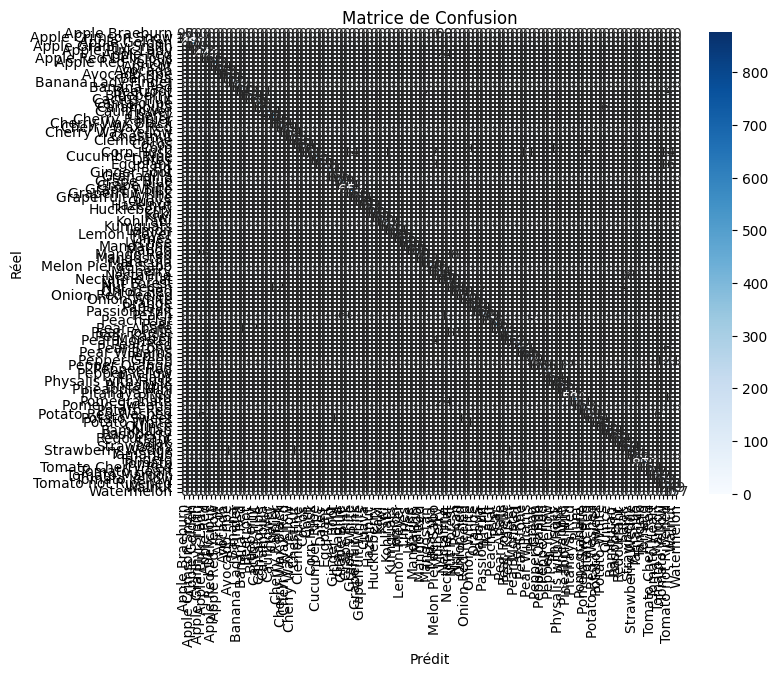

In [19]:
# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 10},
            xticklabels=class_names, yticklabels=class_names)
#sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de Confusion")
plt.show()


In [ ]:
# Rapport de classification
print(classification_report(y_true, y_pred))

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch

# Définir le nombre de classes dans le dataset
num_classes = len(set([sample["label"] for sample in dataset["train"]]))

# Charger MobileNetV2 pré-entraîné
model = models.mobilenet_v2(pretrained=True)

# Geler les poids des couches sauf la dernière
for param in model.features.parameters():
    param.requires_grad = False

# Adapter la dernière couche pour notre dataset
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Définir l'appareil (GPU si disponible, sinon CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Définir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Nombre d'époques et initialisation du suivi des pertes
num_epochs = 10
train_losses = []
test_losses = []

# Boucle d'entraînement
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward et optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculer la perte moyenne par époque
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    print(f"Époque [{epoch+1}/{num_epochs}], Perte: {epoch_loss:.4f}")

print("✅ Entraînement terminé !")


In [ ]:
# ÉVALUATION DU MODÈLE


from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

In [23]:
# Rapport de classification
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       164
           1       1.00      0.97      0.98       148
           2       0.91      0.97      0.94       485
           3       0.90      0.89      0.90       164
           4       0.99      1.00      0.99       152
           5       0.94      0.93      0.94       472
           6       0.99      0.99      0.99       166
           7       1.00      0.99      0.99       383
           8       1.00      1.00      1.00       164
           9       0.99      1.00      1.00       143
          10       1.00      1.00      1.00       166
          11       0.98      0.97      0.97       166
          12       0.98      1.00      0.99       152
          13       1.00      0.97      0.98       166
          14       0.97      0.69      0.81       150
          15       1.00      0.99      1.00       154
          16       0.85      1.00      0.92       166
          17       0.99    

In [24]:
    # Sauvegarde du modèle
    model_save_path = "model_fruits360.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"Modèle sauvegardé avec succès à {model_save_path}!")

Modèle sauvegardé avec succès à model_fruits360.pth!
